## The libraries used

| Library | Description |
|---|---|
| Numpy | Numerical calculation library |
| Flax | For building neural net |
| Optax | Optimization library |
| Matplotlib | Plotting figures |
| Tfds | A library of many datasets including MNIST |
| Treesceope | Pretty printing complex data |

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import optax
import tensorflow_datasets as tfds
from flax import nnx

rngs = nnx.Rngs(0)

import treescope
treescope.register_as_default()
treescope.basic_interactive_setup(autovisualize_arrays=True)

## MNIST Dataset

*   Pictures of hand-writen digits
*   Gray scale (no color)
*   Fixed sized: 28 x 28


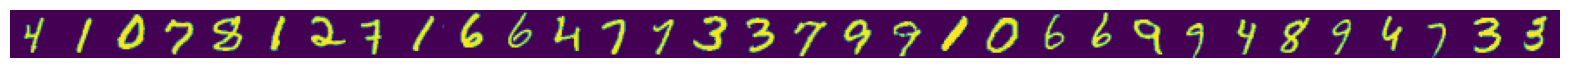

[4 1 0 7 8 1 2 7 1 6 6 4 7 7 3 3 7 9 9 1 0 6 6 9 9 4 8 9 4 7 3 3]


In [2]:
mnist = (
    tfds.load("mnist", as_supervised=True, split='train')
    .batch(32)
    .prefetch(1)
)

def plot_sample(sample):
  plt.figure(figsize=(20, 2))
  plt.imshow(np.hstack(sample[0]))
  plt.axis('off')
  plt.show()
  print(sample[1])

plot_sample(next(mnist.as_numpy_iterator()))

## Our goal is to predict the "digit number" from the picture

Because there are only 10 possible values, we will treat this as a multi-class classification problem.

A common loss function for this is "softmax cross-entropy loss". The loss is computed in three steps:

1. convert the 10-d model prediction to "softmax" values:

$$\mathrm{softmax}(\mathbf{X})_{i} = \frac{\exp(\mathbf{X}_{i})}{\sum_k \exp(\mathbf{X}_{k})}.$$

2. convert the integer label to "one-hot" vectors
  
    e.g. Label: "2" --> One-hot Vecotor: t = (0, 0, 1, 0, 0, 0, 0, 0, 0, 0)

3. compute cross-entropy between the softmax value and the one-hot vector

  $$\mathrm{CE}=-{\sum_i^Ct_i \log \mathrm{softmax}(\mathbf{X})_{i}}.$$

In [3]:
def loss_fn(model, x, y):
  logits = model(x)

  # make sure the model output is a 10-dimensional vector
  assert logits.shape == (x.shape[0], 10)

  loss = optax.softmax_cross_entropy_with_integer_labels(logits, y)

  loss = loss.mean()

  return loss

def train_step(optimizer, x, y):
  ''' Perform one step of training on a minibatch data (x, y)
  '''
  grad = nnx.grad(loss_fn)(optimizer.model, x, y)

  optimizer.update(grad)

## Now we build a neural net model

- Number of input neurons = 28 * 28
- Number of output neurons = 10
- We will have two layers of hidden neurons
- Each hidden layer will have 256 neurons

In [4]:
class MnistNN(nnx.Module):
  def __init__(self, rngs):
    self.layer_1 = nnx.Linear(28*28, 256, rngs=rngs)
    self.layer_2 = nnx.Linear(256, 256, rngs=rngs)
    self.layer_3 = nnx.Linear(256, 10, rngs=rngs)

  def __call__(self, x):
    # flatten the x input
    x = x.reshape(x.shape[0], 28 * 28)

    x = nnx.relu(self.layer_1(x))
    x = nnx.relu(self.layer_2(x))

    # no activation for the last layer
    x = self.layer_3(x)

    return x

model = MnistNN(rngs)
model

MnistNN( # Param: 269,322 (1.1 MB)
  layer_1=Linear( # Param: 200,960 (803.8 KB)
    kernel=Param( # 200,704 (802.8 KB)
      value=Array(shape=(784, 256), dtype=dtype('float32'))
    ),
    bias=Param( # 256 (1.0 KB)
      value=Array(shape=(256,), dtype=dtype('float32'))
    ),
    in_features=784,
    out_features=256,
    use_bias=True,
    dtype=None,
    param_dtype=float32,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x7af96941cf40>,
    bias_init=<function zeros at 0x7af988d55b20>,
    dot_general=<function dot_general at 0x7af9895653a0>,
    promote_dtype=<function promote_dtype at 0x7af96941c7c0>
  ),
  layer_2=Linear( # Param: 65,792 (263.2 KB)
    kernel=Param( # 65,536 (262.1 KB)
      value=Array(shape=(256, 256), dtype=dtype('float32'))
    ),
    bias=Param( # 256 (1.0 KB)
      value=Array(shape=(256,), dtype=dtype('float32'))
    ),
    in_features=256,
    out_features=256,
    use_bias=True,
    dtype=None,
    param_dtype=float32,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x7af96941cf40>,
    bias_init=<function zeros at 0x7af988d55b20>,
    dot_general=<function dot_general at 0x7af9895653a0>,
    promote_dtype=<function promote_dtype at 0x7af96941c7c0>
  ),
  layer_3=Linear( # Param: 2,570 (10.3 KB)
    kernel=Param( # 2,560 (10.2 KB)
      value=Array(shape=(256, 10), dtype=dtype('float32'))
    ),
    bias=Param( # 10 (40 B)
      value=Array(shape=(10,), dtype=dtype('float32'))
    ),
    in_features=256,
    out_features=10,
    use_bias=True,
    dtype=None,
    param_dtype=float32,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x7af96941cf40>,
    bias_init=<function zeros at 0x7af988d55b20>,
    dot_general=<function dot_general at 0x7af9895653a0>,
    promote_dtype=<function promote_dtype at 0x7af96941c7c0>
  )
)

## Training

Training is simple to perform gradient descent on many mini-batches of data

In [5]:
from tqdm import tqdm

optimizer = nnx.Optimizer(model, optax.adam(0.001))

for batch in tqdm(mnist.as_numpy_iterator()):
    train_step(optimizer, *batch)

1875it [01:48, 17.27it/s]


Grund Truth


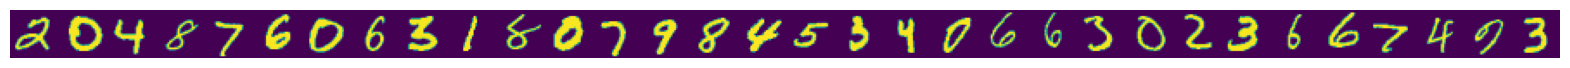

[2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 7 4 9 3]

 Predictions
[2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 9 5 3 9 0 6 6 3 0 2 3 6 6 7 4 0 3]


In [6]:
# Let's check the results

def run_test(model):
  mnist_test = (
      tfds.load("mnist", as_supervised=True, split='test')
      .batch(32)
      .prefetch(1)
  )

  sample = next(mnist_test.as_numpy_iterator())
  print("Grund Truth")
  plot_sample(sample)

  predictions = model(sample[0])
  predictions = np.argmax(predictions, axis=1)
  print("\n Predictions")
  print(predictions)

run_test(model)

## How about a CNN model

 - We need to specify additional hyperparameters: kernel size
 - Also the number of filters D -- the number of hidden neurons = height * width * D

In [7]:
class MnistCNN(nnx.Module):
  def __init__(self, rngs):
    self.layer_1 = nnx.Conv(1, 16, (3, 3), rngs=rngs)
    self.layer_2 = nnx.Conv(16, 4, (3, 3), rngs=rngs)
    self.layer_3 = nnx.Linear(28 * 28 * 4, 10, rngs=rngs)

  def __call__(self, x):
    x = nnx.relu(self.layer_1(x))
    x = nnx.relu(self.layer_2(x))

    # flatten
    x = x.reshape(x.shape[0], -1)

    # output
    x = self.layer_3(x)

    return x

cnn_model = MnistCNN(rngs)
cnn_model

MnistCNN( # Param: 32,110 (128.4 KB)
  layer_1=Conv( # Param: 160 (640 B)
    kernel_shape=(3, 3, 1, 16),
    kernel=Param( # 144 (576 B)
      value=Array(shape=(3, 3, 1, 16), dtype=dtype('float32'))
    ),
    bias=Param( # 16 (64 B)
      value=Array(shape=(16,), dtype=dtype('float32'))
    ),
    in_features=1,
    out_features=16,
    kernel_size=(3, 3),
    strides=1,
    padding='SAME',
    input_dilation=1,
    kernel_dilation=1,
    feature_group_count=1,
    use_bias=True,
    mask=None,
    dtype=None,
    param_dtype=float32,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x7af96941cf40>,
    bias_init=<function zeros at 0x7af988d55b20>,
    conv_general_dilated=<function conv_general_dilated at 0x7af9895d7880>,
    promote_dtype=<function promote_dtype at 0x7af96941c7c0>
  ),
  layer_2=Conv( # Param: 580 (2.3 KB)
    kernel_shape=(3, 3, 16, 4),
    kernel=Param( # 576 (2.3 KB)
      value=Array(shape=(3, 3, 16, 4), dtype=dtype('float32'))
    ),
    bias=Param( # 4 (16 B)
      value=Array(shape=(4,), dtype=dtype('float32'))
    ),
    in_features=16,
    out_features=4,
    kernel_size=(3, 3),
    strides=1,
    padding='SAME',
    input_dilation=1,
    kernel_dilation=1,
    feature_group_count=1,
    use_bias=True,
    mask=None,
    dtype=None,
    param_dtype=float32,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x7af96941cf40>,
    bias_init=<function zeros at 0x7af988d55b20>,
    conv_general_dilated=<function conv_general_dilated at 0x7af9895d7880>,
    promote_dtype=<function promote_dtype at 0x7af96941c7c0>
  ),
  layer_3=Linear( # Param: 31,370 (125.5 KB)
    kernel=Param( # 31,360 (125.4 KB)
      value=Array(shape=(3136, 10), dtype=dtype('float32'))
    ),
    bias=Param( # 10 (40 B)
      value=Array(shape=(10,), dtype=dtype('float32'))
    ),
    in_features=3136,
    out_features=10,
    use_bias=True,
    dtype=None,
    param_dtype=float32,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x7af96941cf40>,
    bias_init=<function zeros at 0x7af988d55b20>,
    dot_general=<function dot_general at 0x7af9895653a0>,
    promote_dtype=<function promote_dtype at 0x7af96941c7c0>
  )
)

1875it [01:52, 16.64it/s]


Grund Truth


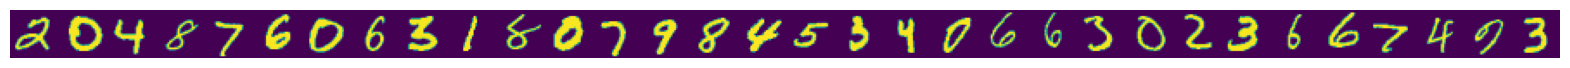

[2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 7 4 9 3]

 Predictions
[2 0 4 8 7 6 0 6 5 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 7 4 9 3]


In [8]:
from tqdm import tqdm

optimizer = nnx.Optimizer(cnn_model, optax.adam(0.001))

for batch in tqdm(mnist.as_numpy_iterator()):
    train_step(optimizer, *batch)

# check the results
run_test(cnn_model)